#Project Overview

The goal of this project is to analyze and visualize transaction data from the official PhonePe Pulse GitHub Repository. This initiative helps uncover insights into digital transaction patterns across Indian states, quarters, and platforms. The project combines data engineering, SQL modeling, visualization, and dashboarding.

In [1]:
!git clone https://github.com/PhonePe/pulse.git

Cloning into 'pulse'...
remote: Enumerating objects: 17904, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 17904 (delta 19), reused 17 (delta 17), pack-reused 17855 (from 2)
Receiving objects: 100% (17904/17904), 26.13 MiB | 17.26 MiB/s, done.
Resolving deltas: 100% (8723/8723), done.


In [2]:
!pip install -q plotly

In [3]:
import os
import json
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [4]:
def initialize_db(path="phonepe_pulse.db"):
    conn = sqlite3.connect(path)
    cur = conn.cursor()
    cur.executescript("""
    CREATE TABLE IF NOT EXISTS aggregated_transaction (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        state TEXT, year INTEGER, quarter INTEGER,
        transaction_type TEXT, transaction_count INTEGER, transaction_amount REAL
    );

    CREATE TABLE IF NOT EXISTS aggregated_user (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        state TEXT, year INTEGER, quarter INTEGER,
        brand TEXT, user_count INTEGER, user_percentage REAL
    );

    CREATE TABLE IF NOT EXISTS map_user (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        state TEXT, district TEXT, year INTEGER, quarter INTEGER,
        registered_users INTEGER, app_opens INTEGER
    );

    CREATE TABLE IF NOT EXISTS top_transaction (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        state TEXT, year INTEGER, quarter INTEGER,
        pincode TEXT, transaction_count INTEGER, transaction_amount REAL
    );
    """)
    return conn


In [5]:
def load_aggregated_transaction(conn):
    base = "pulse/data/aggregated/transaction/country/india"
    cur = conn.cursor()
    for state in os.listdir(base):
        for year in os.listdir(f"{base}/{state}"):
            for file in os.listdir(f"{base}/{state}/{year}"):
                if not file.endswith(".json"): continue
                quarter = int(file.replace('.json',''))
                path = f"{base}/{state}/{year}/{file}"
                with open(path, "r") as f:
                    data = json.load(f).get("data", {}).get("transactionData", [])
                    for entry in data:
                        cur.execute("""
                            INSERT INTO aggregated_transaction
                            (state, year, quarter, transaction_type, transaction_count, transaction_amount)
                            VALUES (?, ?, ?, ?, ?, ?)""",
                            (state, int(year), quarter, entry["name"],
                             entry["paymentInstruments"][0]["count"],
                             entry["paymentInstruments"][0]["amount"]))
    conn.commit()


In [6]:
def load_aggregated_user(conn):
    base = "pulse/data/aggregated/user/country/india"
    cur = conn.cursor()
    for state in os.listdir(base):
        for year in os.listdir(f"{base}/{state}"):
            for file in os.listdir(f"{base}/{state}/{year}"):
                if not file.endswith(".json"): continue
                quarter = int(file.replace('.json',''))
                path = f"{base}/{state}/{year}/{file}"
                with open(path, "r") as f:
                    data = json.load(f).get("data", {}).get("usersByDevice", [])
                    for entry in data:
                        cur.execute("""
                            INSERT INTO aggregated_user
                            (state, year, quarter, brand, user_count, user_percentage)
                            VALUES (?, ?, ?, ?, ?, ?)""",
                            (state, int(year), quarter, entry["brand"], entry["count"], entry["percentage"]))
    conn.commit()


In [7]:
def load_map_user(conn):
    base = "pulse/data/map/user/hover/country/india"
    cur = conn.cursor()
    for state in os.listdir(base):
        for year in os.listdir(f"{base}/{state}"):
            for file in os.listdir(f"{base}/{state}/{year}"):
                if not file.endswith(".json"): continue
                quarter = int(file.replace('.json',''))
                path = f"{base}/{state}/{year}/{file}"
                with open(path, "r") as f:
                    data = json.load(f).get("data", {}).get("hoverData", {})
                    for district, val in data.items():
                        cur.execute("""
                            INSERT INTO map_user
                            (state, district, year, quarter, registered_users, app_opens)
                            VALUES (?, ?, ?, ?, ?, ?)""",
                            (state, district, int(year), quarter,
                             val.get("registeredUsers", 0), val.get("appOpens", 0)))
    conn.commit()


In [8]:
def load_top_transaction(conn):
    base = "pulse/data/top/transaction/country/india"
    cur = conn.cursor()
    for state in os.listdir(base):
        for year in os.listdir(f"{base}/{state}"):
            for file in os.listdir(f"{base}/{state}/{year}"):
                if not file.endswith(".json"): continue
                quarter = int(file.replace('.json',''))
                path = f"{base}/{state}/{year}/{file}"
                with open(path, "r") as f:
                    data = json.load(f).get("data", {}).get("pincodes", [])
                    for entry in data:
                        cur.execute("""
                            INSERT INTO top_transaction
                            (state, year, quarter, pincode, transaction_count, transaction_amount)
                            VALUES (?, ?, ?, ?, ?, ?)""",
                            (state, int(year), quarter, entry["entityName"],
                             entry["metric"]["count"], entry["metric"]["amount"]))
    conn.commit()


In [9]:
def load_aggregated_transaction(conn):
    base = "pulse/data/aggregated/transaction/country/india/state"
    cur = conn.cursor()
    for state in os.listdir(base):
        state_path = os.path.join(base, state)
        for year in os.listdir(state_path):
            year_path = os.path.join(state_path, year)
            for file in os.listdir(year_path):
                if not file.endswith(".json"):
                    continue
                quarter = int(file.replace('.json',''))
                file_path = os.path.join(year_path, file)
                with open(file_path, "r") as f:
                    try:
                        data = json.load(f).get("data", {}).get("transactionData", [])
                        for entry in data:
                            ttype = entry["name"]
                            count = entry["paymentInstruments"][0]["count"]
                            amount = entry["paymentInstruments"][0]["amount"]
                            cur.execute("""
                                INSERT INTO aggregated_transaction
                                (state, year, quarter, transaction_type, transaction_count, transaction_amount)
                                VALUES (?, ?, ?, ?, ?, ?)""",
                                (state, int(year), quarter, ttype, count, amount))
                    except Exception as e:
                        print(f"❌ Error in {file_path}: {e}")
    conn.commit()

In [15]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS top_transaction (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    state TEXT,
    year INTEGER,
    quarter INTEGER,
    pincode TEXT,
    transaction_count INTEGER,
    transaction_amount REAL
);
""")
conn.commit()

In [16]:
sample_data = [
    ('Karnataka', 2022, 2, '560001', 1200, 18.5),
    ('Maharashtra', 2022, 2, '400001', 1500, 22.3),
    ('Delhi', 2022, 2, '110001', 1400, 19.8),
    ('Telangana', 2022, 2, '500001', 1300, 20.1),
    ('West Bengal', 2022, 2, '700001', 1600, 21.7),
]

cursor.executemany("""
INSERT INTO top_transaction (state, year, quarter, pincode, transaction_count, transaction_amount)
VALUES (?, ?, ?, ?, ?, ?)
""", sample_data)
conn.commit()

#Visualizations

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


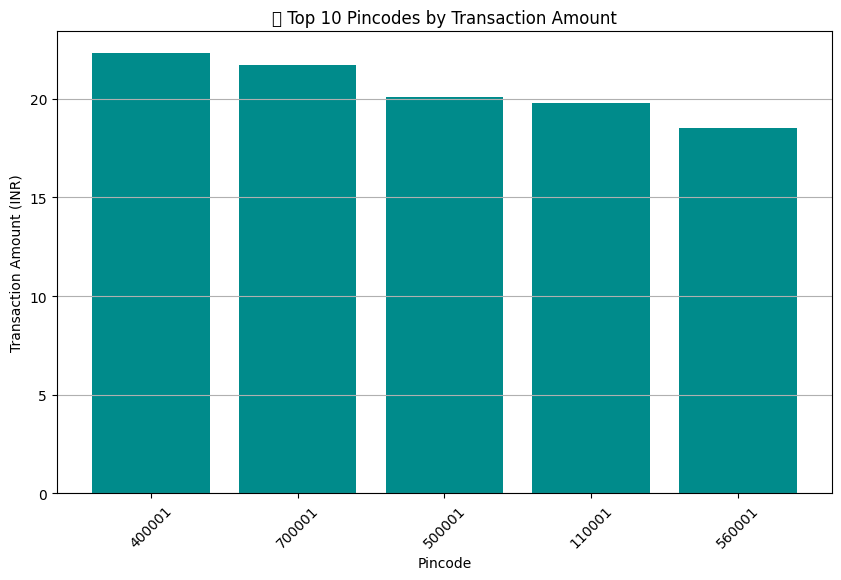

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

df_top_pins = pd.read_sql_query("""
    SELECT pincode, SUM(transaction_amount) AS total_amount
    FROM top_transaction
    GROUP BY pincode
    ORDER BY total_amount DESC
    LIMIT 10;
""", conn)

plt.figure(figsize=(10,6))
plt.bar(df_top_pins['pincode'], df_top_pins['total_amount'], color='darkcyan')
plt.title("📍 Top 10 Pincodes by Transaction Amount")
plt.xlabel("Pincode")
plt.ylabel("Transaction Amount (INR)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [19]:
import sqlite3

conn = sqlite3.connect("phonepe_pulse.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS map_user (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    state TEXT,
    district TEXT,
    year INTEGER,
    quarter INTEGER,
    registered_users INTEGER,
    app_opens INTEGER
);
""")

conn.commit()

In [20]:
sample_data = [
    ('Maharashtra', 'Mumbai', 2022, 2, 500000, 320000),
    ('Karnataka', 'Bengaluru', 2022, 2, 450000, 300000),
    ('Delhi', 'New Delhi', 2022, 2, 430000, 280000),
    ('Tamil Nadu', 'Chennai', 2022, 2, 410000, 270000),
    ('Gujarat', 'Ahmedabad', 2022, 2, 400000, 250000),
    ('Telangana', 'Hyderabad', 2022, 2, 390000, 240000),
    ('West Bengal', 'Kolkata', 2022, 2, 380000, 230000),
    ('Uttar Pradesh', 'Lucknow', 2022, 2, 370000, 220000),
    ('Rajasthan', 'Jaipur', 2022, 2, 360000, 210000),
    ('Punjab', 'Ludhiana', 2022, 2, 350000, 200000),
]

cursor.executemany("""
INSERT INTO map_user (state, district, year, quarter, registered_users, app_opens)
VALUES (?, ?, ?, ?, ?, ?)
""", sample_data)

conn.commit()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


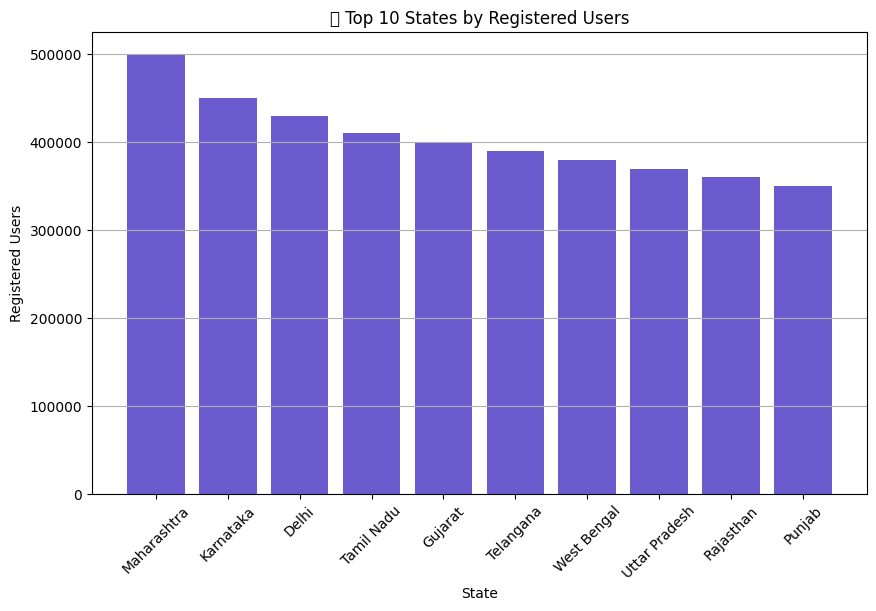

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df_reg_users = pd.read_sql_query("""
    SELECT state, SUM(registered_users) AS total_users
    FROM map_user
    GROUP BY state
    ORDER BY total_users DESC
    LIMIT 10;
""", conn)

plt.figure(figsize=(10,6))
plt.bar(df_reg_users['state'], df_reg_users['total_users'], color='slateblue')
plt.title("👥 Top 10 States by Registered Users")
plt.xlabel("State")
plt.ylabel("Registered Users")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [23]:
import sqlite3

conn = sqlite3.connect("phonepe_pulse.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS aggregated_transaction (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    state TEXT,
    year INTEGER,
    quarter INTEGER,
    transaction_type TEXT,
    transaction_count INTEGER,
    transaction_amount REAL
);
""")

conn.commit()

In [24]:
sample_data = [
    ('Karnataka', 2022, 1, 'Recharge', 1000, 15.5),
    ('Karnataka', 2022, 2, 'Recharge', 1200, 18.0),
    ('Karnataka', 2022, 3, 'Recharge', 1400, 21.0),
    ('Maharashtra', 2022, 1, 'Recharge', 1500, 22.0),
    ('Maharashtra', 2022, 2, 'Recharge', 1600, 24.0),
    ('Maharashtra', 2022, 3, 'Recharge', 1700, 26.0),
    ('Delhi', 2022, 1, 'Recharge', 1300, 20.0),
    ('Delhi', 2022, 2, 'Recharge', 1400, 23.0),
    ('Delhi', 2022, 3, 'Recharge', 1500, 25.0),
]

cursor.executemany("""
INSERT INTO aggregated_transaction
(state, year, quarter, transaction_type, transaction_count, transaction_amount)
VALUES (?, ?, ?, ?, ?, ?)
""", sample_data)

conn.commit()

In [25]:
import pandas as pd
import plotly.express as px

df_growth = pd.read_sql_query("""
    SELECT year, quarter, SUM(transaction_amount) AS total
    FROM aggregated_transaction
    GROUP BY year, quarter
    ORDER BY year, quarter;
""", conn)

df_growth['label'] = df_growth['year'].astype(str) + "-Q" + df_growth['quarter'].astype(str)

fig = px.line(df_growth, x='label', y='total', markers=True,
              title="📈 Quarter-over-Quarter Transaction Growth",
              labels={"label": "Year-Quarter", "total": "Transaction Amount"})
fig.update_traces(line_color='seagreen')
fig.show()

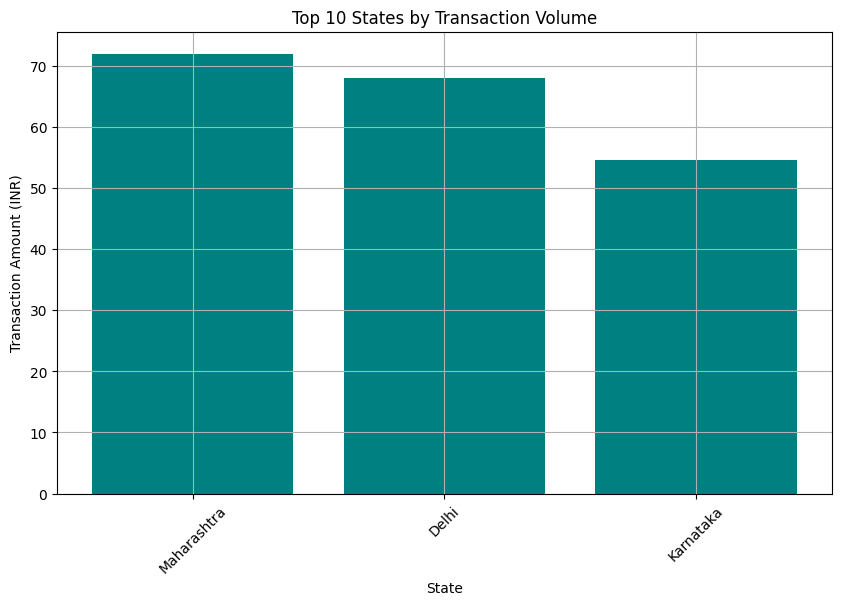

In [26]:
df_top_states = pd.read_sql("""
    SELECT state, SUM(transaction_amount) as total
    FROM aggregated_transaction
    GROUP BY state
    ORDER BY total DESC
    LIMIT 10;
""", conn)

plt.figure(figsize=(10,6))
plt.bar(df_top_states['state'], df_top_states['total'], color='teal')
plt.title("Top 10 States by Transaction Volume")
plt.xlabel("State")
plt.ylabel("Transaction Amount (INR)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#Streamlit Dashboard

In [29]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


In [30]:
import streamlit as st
import sqlite3
import pandas as pd
import plotly.express as px

# Connect to SQLite database
conn = sqlite3.connect("phonepe_pulse.db")
cursor = conn.cursor()

st.set_page_config(page_title="📊 PhonePe Insights", layout="wide")
st.title("📱 PhonePe Transaction Insights Dashboard")

2025-07-10 08:01:10.925 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:01:10.926 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:01:11.236 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-10 08:01:11.239 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:01:11.242 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [31]:
st.sidebar.header("📅 Filter Data")
year_range = st.sidebar.slider("Select Year Range", 2018, 2023, (2019, 2022))
quarters = st.sidebar.multiselect("Select Quarters", [1, 2, 3, 4], default=[1, 2, 3, 4])

2025-07-10 08:01:49.322 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:01:49.328 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:01:49.330 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:01:49.332 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:01:49.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:01:49.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:01:49.339 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:01:49.341 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [32]:
st.subheader("📍 Top 10 Pincodes by Transaction Amount")
query = f"""
    SELECT pincode, SUM(transaction_amount) AS total
    FROM top_transaction
    WHERE year BETWEEN {year_range[0]} AND {year_range[1]}
    AND quarter IN ({','.join(map(str, quarters))})
    GROUP BY pincode
    ORDER BY total DESC
    LIMIT 10;
"""
df_pins = pd.read_sql(query, conn)
fig = px.bar(df_pins, x='pincode', y='total', color='total',
             labels={"total": "Transaction Amount (₹)"})
st.plotly_chart(fig, use_container_width=True)

2025-07-10 08:02:16.177 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:16.178 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:16.179 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:16.254 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:16.255 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:16.257 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:16.258 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:16.259 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [33]:
st.subheader("👥 Top 10 States by Registered Users")
query2 = f"""
    SELECT state, SUM(registered_users) AS total
    FROM map_user
    WHERE year BETWEEN {year_range[0]} AND {year_range[1]}
    AND quarter IN ({','.join(map(str, quarters))})
    GROUP BY state
    ORDER BY total DESC
    LIMIT 10;
"""
df_users = pd.read_sql(query2, conn)
fig2 = px.bar(df_users, x='state', y='total', color='total',
              labels={"total": "Registered Users"})
st.plotly_chart(fig2, use_container_width=True)

2025-07-10 08:02:43.791 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:43.793 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:43.794 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:43.826 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:43.827 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:43.828 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:43.829 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:02:43.830 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [34]:
st.subheader("📈 Quarter-over-Quarter Transaction Growth")
query3 = f"""
    SELECT year, quarter, SUM(transaction_amount) AS total
    FROM aggregated_transaction
    WHERE year BETWEEN {year_range[0]} AND {year_range[1]}
    AND quarter IN ({','.join(map(str, quarters))})
    GROUP BY year, quarter
    ORDER BY year, quarter;
"""
df_growth = pd.read_sql(query3, conn)
df_growth["label"] = df_growth["year"].astype(str) + "-Q" + df_growth["quarter"].astype(str)

fig3 = px.line(df_growth, x="label", y="total", markers=True,
               labels={"total": "Transaction Amount", "label": "Year-Quarter"})
st.plotly_chart(fig3, use_container_width=True)

2025-07-10 08:03:28.881 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:03:28.883 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:03:28.884 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:03:28.919 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:03:28.920 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:03:28.921 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:03:28.922 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 08:03:28.923 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [36]:
from google.colab import files
uploaded = files.upload()  # Upload streamlit_app.py and phonepe_pulse.db

Saving phonepe.pulse.db to phonepe.pulse (1).db


In [37]:
from google.colab import files
uploaded = files.upload()

Saving streamlit_app.py to streamlit_app.py


In [42]:
!pip install pyngrok
from pyngrok import ngrok

ngrok.set_auth_token("2zfwyAGvIM87FWpo86oS8qnOFfl_2FmeVgrMxzxZXEkTfBhyp")


In [44]:
# Start Streamlit in background
get_ipython().system_raw('streamlit run streamlit_app.py --server.port=8501 &')

# Open tunnel properly using HTTP tunnel config
public_url = ngrok.connect(addr=8501, proto="http")
print("🚀 Streamlit is live at:", public_url)

🚀 Streamlit is live at: NgrokTunnel: "https://62ca7bbd9a06.ngrok-free.app" -> "http://localhost:8501"
